In [1]:
ciaover -v

The current environment is configured for:
  CIAO        : CIAO 4.15 Monday, November 21, 2022
  Tools       : Package release 1  Monday, November 21, 2022
  Sherpa      : Package release 1  Monday, November 21, 2022
  Obsvis      : Not Installed
  Core        : Package release 1  Monday, November 21, 2022
  Contrib     : Package release 1  Tuesday, January 24, 2023
  bindir      : /export/ciao_from_source/ciao-4.15/bin
  Python path : /export/ciao_from_source/ciao-4.15/ots/bin
  CALDB       : 4.10.4

CIAO Installation: Linux
System information:
Linux lenin.cfa.harvard.edu 4.18.0-425.13.1.el8_7.x86_64 #1 SMP Thu Feb 2 13:01:45 EST 2023 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
/bin/rm -rf 16014
download_chandra_obsid 16014 --exclude evt2,vvref,adat,eph1,osol,full_img,cntr_img,oif,aqual,readme --quiet
chandra_repro 16014 out= mode=h clob+ verb=0
fluximage 16014/repro/acisf16014_repro_evt2.fits"[ccd_id=7]" out=ngc7618 \
  bin=1 psfecf=0.5 mode=h clob+ verb=0

Output from acis_process_events:
# acis_process_events (CIAO 4.15): The following error occurred 27 times:
	dsAPEPULSEHEIGHTERR -- WARNING: pulse height is less than split threshold when performing serial CTI adjustment.


In [3]:
punlearn wavdetect wrecon wtransform
pset wavdetect \
  infile=ngc7618_broad_thresh.img expfile=ngc7618_broad_thresh.expmap psffile=ngc7618_broad_thresh.psfmap \
  outfile=wav.src defn=wav.nbkg scell=wav.cell image=wav.recon \
  scales="1.4 2 4 8 12" 

wavdetect mode=h clobber=yes

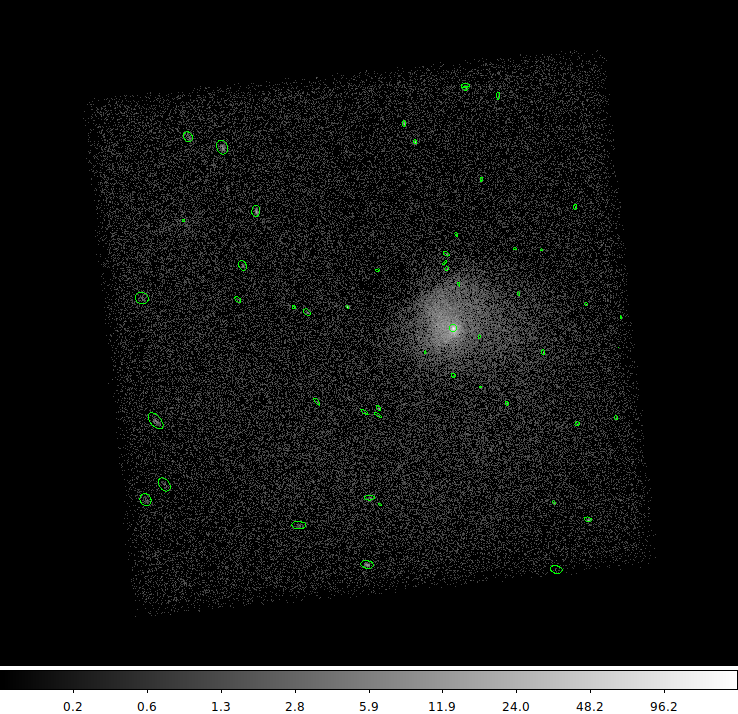

In [4]:
ds9 ngc7618_broad_thresh.img -block to 2 -region load wav.src \
  -saveimage png ds9_01.png -quit

display < ds9_01.png

In [5]:
psfsize_srcs \
  infile=ngc7618_broad_thresh.img \
  pos=wav.src"[exclude (x,y)=circle(3976,4057,2)]" \
  outfile=psfsize.src ecf=0.9 energy=1.0 mode=h clob+

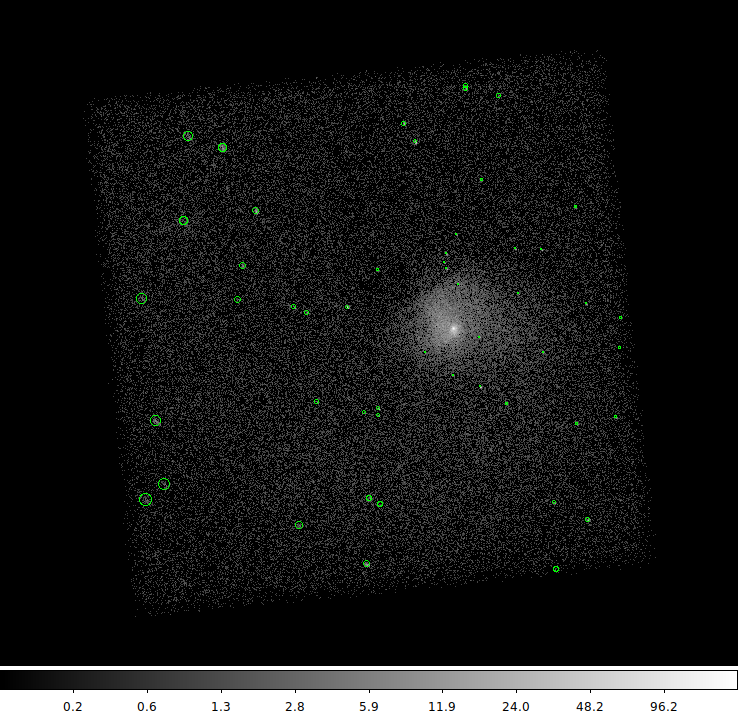

In [6]:
ds9 ngc7618_broad_thresh.img -block to 2 -region load psfsize.src \
  -saveimage png ds9_02.png -quit

display < ds9_02.png

In [7]:
/bin/rm -rf regions
mkdir regions

punlearn roi
roi infile=psfsize.src fovregion="region(ngc7618_16014.fov)" \
  outsrc="regions/%04d.reg" \
  bkgradius=5 group=exclude targetbkg=target \
  compute- clob+ mode=h

# roi (CIAO 4.15): WARNING: Could not find column 'ROTANG' in file 'psfsize.src', assuming all are 0.0


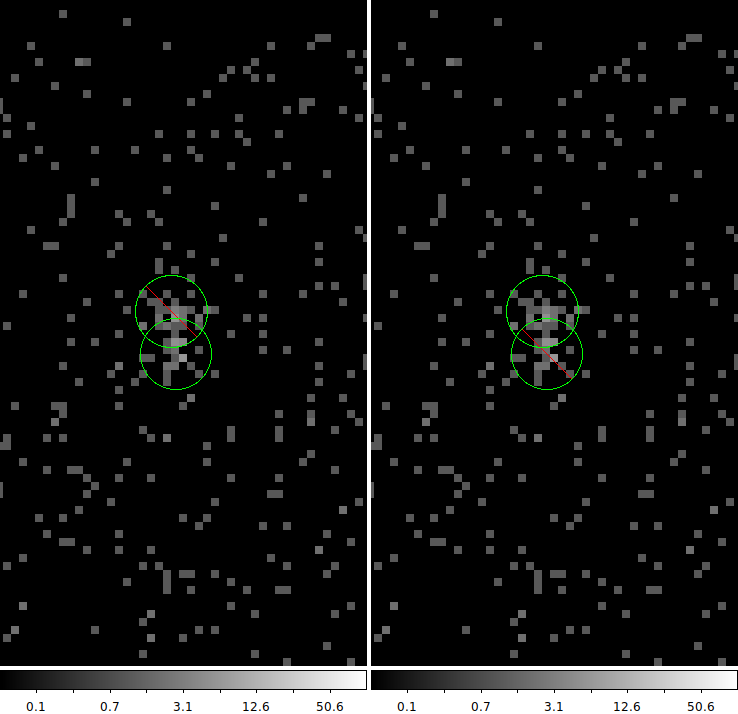

In [8]:
ds9 ngc7618_broad_thresh.img -zoom to 8 \
  -pan to 4003 4540 physical \
  -regions load regions/0040.reg \
  ngc7618_broad_thresh.img \
  -pan to 4003 4540 physical \
  -regions load regions/0041.reg \
  -tile column \
  -saveimage png ds9_02a.png -quit

display < ds9_02a.png
  
    

In [9]:
/bin/rm -rf ranked_regions
mkdir ranked_regions
punlearn rank_roi

rank_roi ngc7618_broad_thresh.img roi="regions/????.reg" out="ranked_regions/{:04d}.reg" method=max clob+

rank_roi
          infile = ngc7618_broad_thresh.img
        roifiles = regions/????.reg
         outfile = ranked_regions/{:04d}.reg
          method = max
         clobber = yes
         verbose = 1
            mode = ql

Loading ROI files
51 ROI files parsed
Checking clobber
Checking infile (image v. table)
Computing metric for all ROIs
Determining which ROIs should get overlap area
Writing out new roi files


[1] 51641
[1]+  Done                    ds9 ngc7618_broad_thresh.img -block to 2


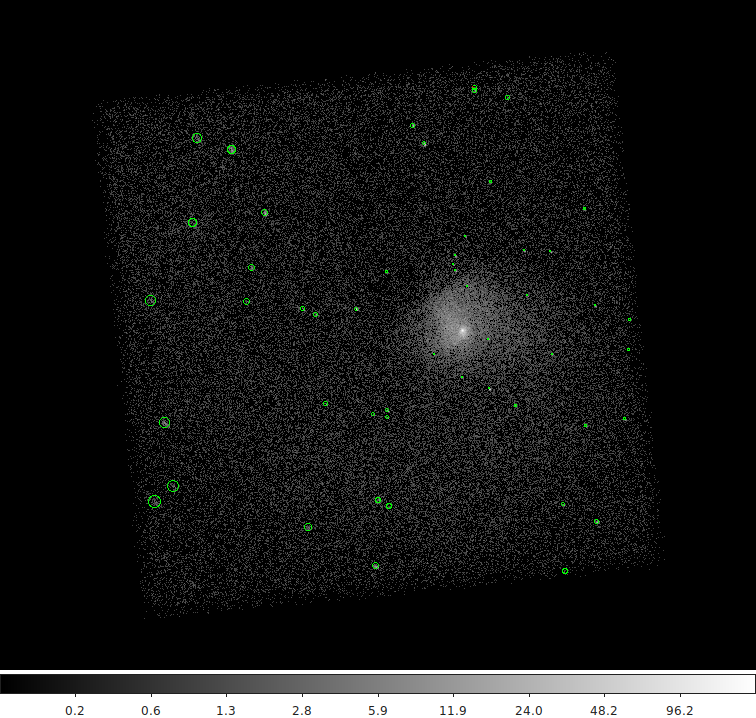

In [10]:
ds9 ngc7618_broad_thresh.img -block to 2 &
sleep 5
/bin/ls ranked_regions/????.reg | xargs -I@ xpaset -p ds9 region load @
xpaset -p ds9 saveimage png ds9_03.png 
xpaset -p ds9 quit

display < ds9_03.png

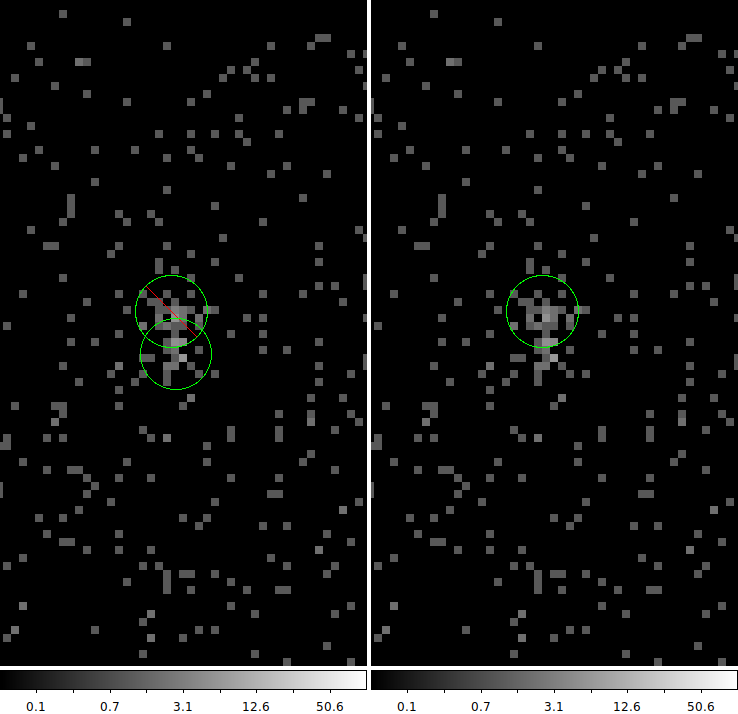

In [11]:
ds9 ngc7618_broad_thresh.img -zoom to 8 \
  -pan to 4003 4540 physical \
  -regions load ranked_regions/0040.reg \
  ngc7618_broad_thresh.img \
  -pan to 4003 4540 physical \
  -regions load ranked_regions/0041.reg \
  -tile column \
  -saveimage png ds9_03a.png -quit

display < ds9_03a.png
  
    

[1] 53015
[1]+  Done                    ds9 ngc7618_broad_thresh.img -block to 2


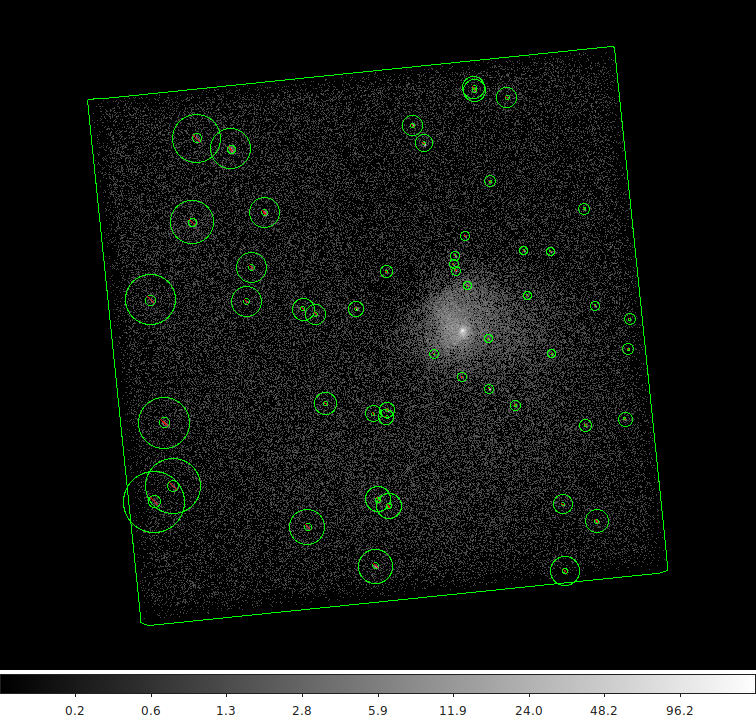

In [12]:
ds9 ngc7618_broad_thresh.img -block to 2 &
sleep 5
/bin/ls ranked_regions/????.reg | xargs -I@ xpaset -p ds9 region load @"[bkgreg]"
xpaset -p ds9 saveimage png ds9_04.png 
xpaset -p ds9 quit

display < ds9_04.png

In [13]:
/bin/ls ranked_regions/????.reg | sed 's,.*,region(&[srcreg]),' > src.lis
/bin/ls ranked_regions/????.reg | sed 's,.*,region(&[bkgreg]),' > bkg.lis

In [14]:
punlearn dmfilth
dmfilth ngc7618_broad_thresh.img ngc7618.filled \
  src=@src.lis bkg=@bkg.lis method=POISSON clob+

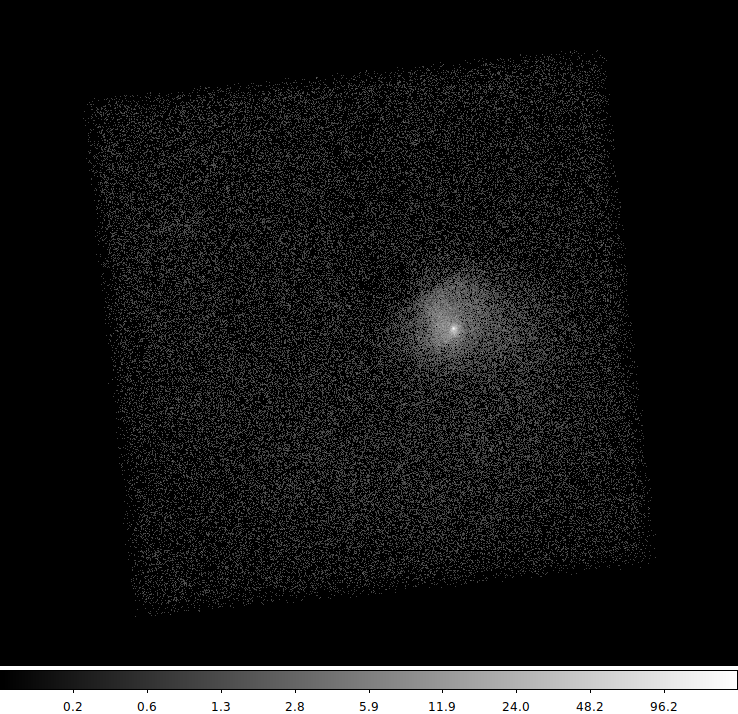

In [15]:
ds9 ngc7618.filled -block to 2 \
  -saveimage png ds9_05.png -quit

display < ds9_05.png

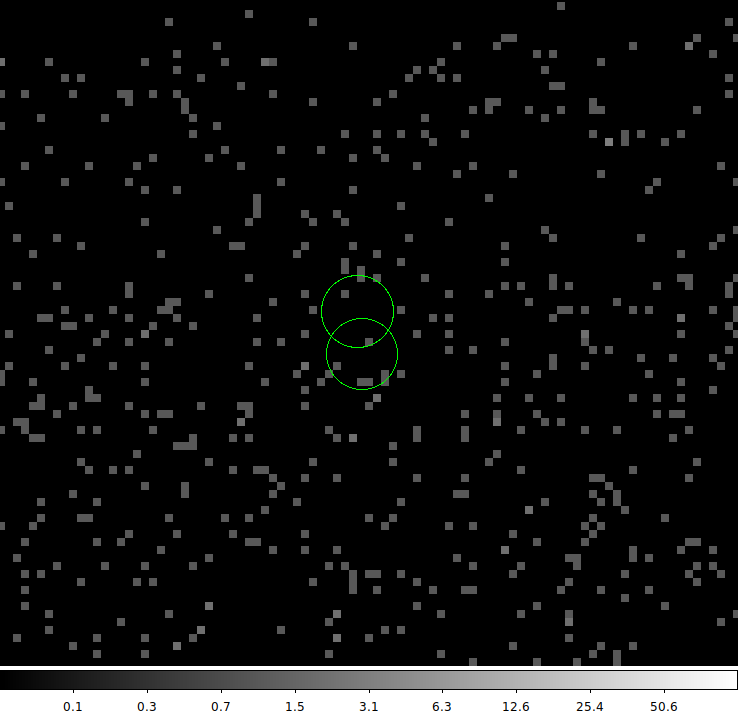

In [16]:
ds9 ngc7618.filled -zoom to 8 \
  -pan to 4003 4540 physical \
  -regions load psfsize.src \
  -saveimage png ds9_05a.png -exit

display < ds9_05a.png

In [17]:
punlearn dmradar

dmradar ngc7618.filled"[sky=region(ngc7618_16014.fov)][opt full]" \
  outfile=ngc7618.abin outmask=ngc7618.map \
  snr=7.071 xcenter=3976 ycenter=4057 method=4 \
  shape=pie router=750 rinner=4 minradius=2 minangle=1 \
  mode=h clob+

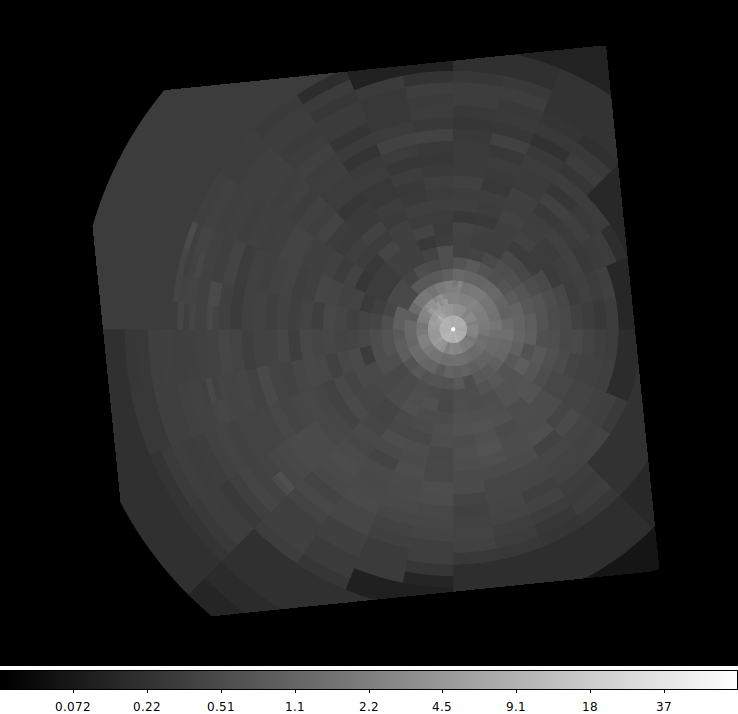

In [18]:
ds9 ngc7618.abin -block to 2 \
  -saveimage png ds9_06.png -quit

display < ds9_06.png

In [19]:
cat << EOM | python
from region import CXCRegion,field
out=field()-CXCRegion("psfsize.src")
out.write("exclude.src", fits=True, clobber=True)
EOM

dmcopy "16014/repro/acisf16014_repro_evt2.fits[sky=region(exclude.src)]" no_point_srcs.evt clob+

In [20]:
punlearn statmap
statmap no_point_srcs.evt"[ccd_id=7,energy=500:7000]" \
  ngc7618.map \
  outfile=ngc7618_median_energy.map \
  column=energy stat=median clob+

statmap
          infile = no_point_srcs.evt[ccd_id=7,energy=500:7000]
         mapfile = ngc7618.map
         outfile = ngc7618_median_energy.map
          column = energy
       statistic = median
         xcolumn = x
         ycolumn = y
         clobber = yes
         verbose = 1
            mode = ql



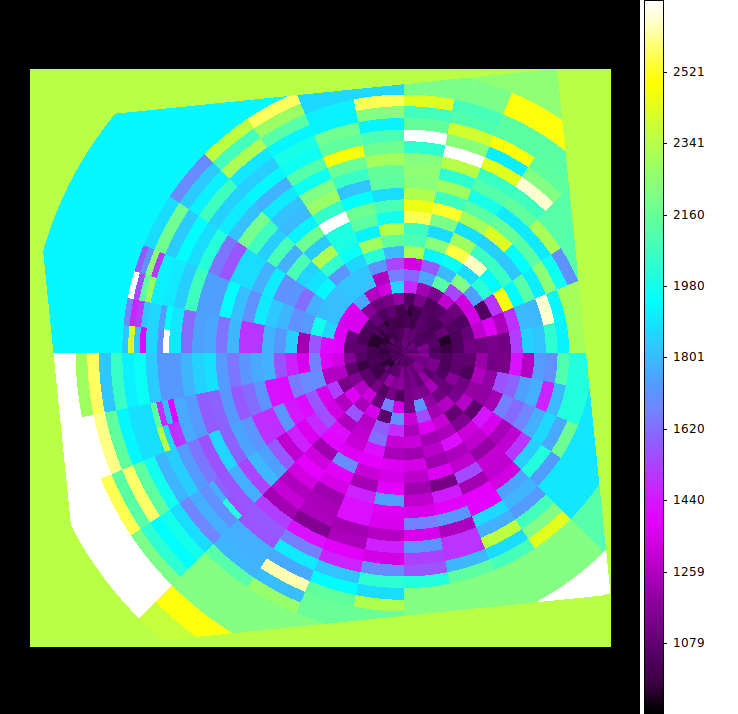

In [21]:
ds9 ngc7618_median_energy.map -zoom to 0.5 \
  -scale linear -scale limits 900 2700 \
  -cmap load $ASCDS_CONTRIB/data/purby.lut \
  -colorbar vertical \
  -saveimage png ds9_07.png -quit

display < ds9_07.png

In [22]:
aconvolve ngc7618.map"[opt type=i4]" ngc7618.grid "txt:((1,1,1),(1,-8,1),(1,1,1))" norm=none mode=h clob+

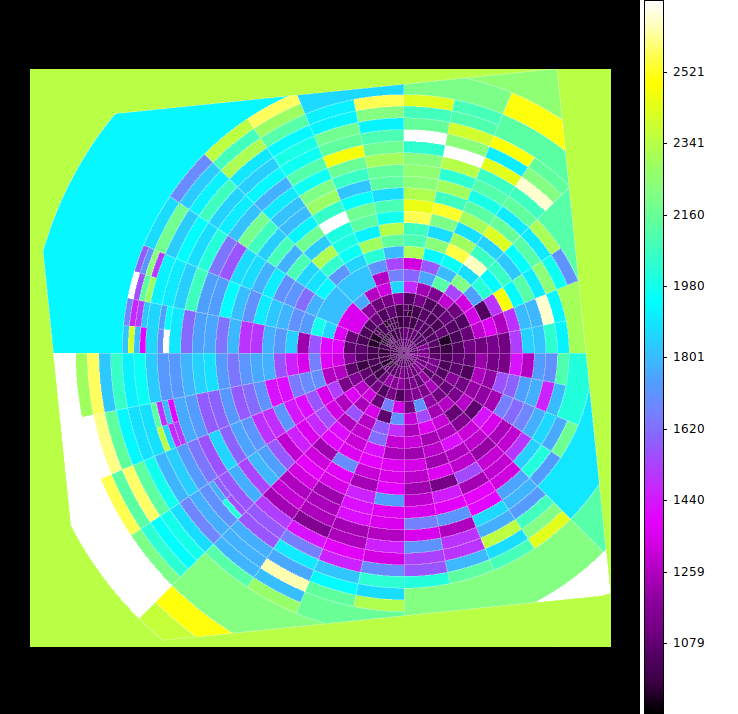

In [23]:
ds9 ngc7618_median_energy.map -zoom to 0.5 \
  -mask color white -mask transparency 70 -mask ngc7618.grid \
  -scale linear -scale limits 900 2700 \
  -cmap load $ASCDS_CONTRIB/data/purby.lut \
  -colorbar vertical \
  -saveimage png ds9_08.png -quit

display < ds9_08.png

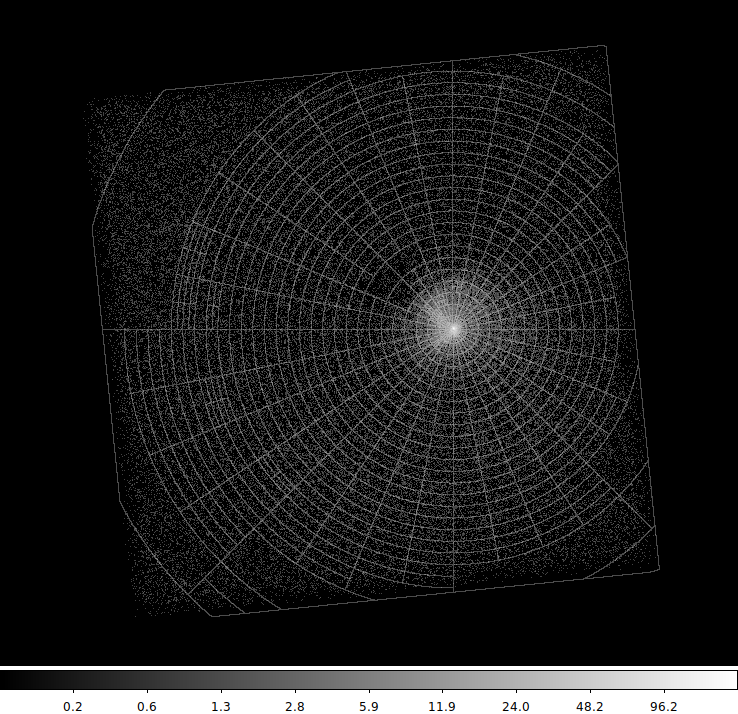

In [24]:
ds9 ngc7618.filled -block to 2 \
  -mask color white -mask transparency 70 -mask ngc7618.grid \
  -saveimage png ds9_09.png -quit

display < ds9_09.png

### `mean_energy_map`

In [25]:
punlearn mean_energy_map
mean_energy_map no_point_srcs.evt"[ccd_id=7,energy=500:7000]" \
  outfile=ngc7618_me.map \
  bin=8 clob+  
  

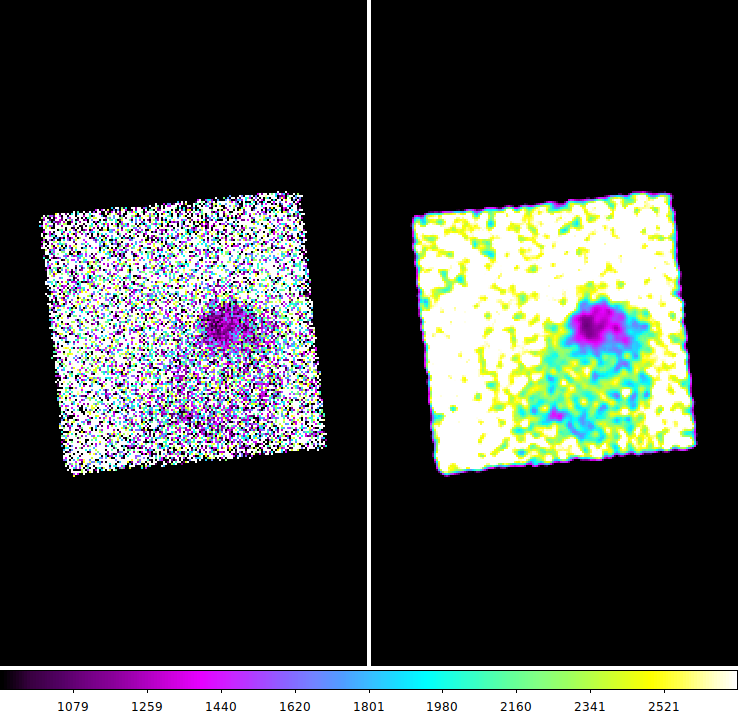

In [26]:
ds9 -view multi no\
  ngc7618_me.map -zoom to 2 \
  -pan to 3809 4048 physical \
  -scale linear -scale limits 900 2700 \
  -cmap load $ASCDS_CONTRIB/data/purby.lut \
  -colorbar vertical \
  ngc7618_me.map -zoom to 2 \
  -pan to 3809 4048 physical \
  -scale linear -scale limits 900 2700 \
  -cmap load $ASCDS_CONTRIB/data/purby.lut \
  -colorbar horizontal \
  -smooth \
  -saveimage png ds9_10.png -quit

display < ds9_10.png

### Other statistics

In [27]:
punlearn statmap
statmap no_point_srcs.evt"[ccd_id=7,energy=500:7000]" \
  ngc7618.map \
  outfile=ngc7618_count.map \
  column=energy stat=count clob+

statmap
          infile = no_point_srcs.evt[ccd_id=7,energy=500:7000]
         mapfile = ngc7618.map
         outfile = ngc7618_count.map
          column = energy
       statistic = count
         xcolumn = x
         ycolumn = y
         clobber = yes
         verbose = 1
            mode = ql



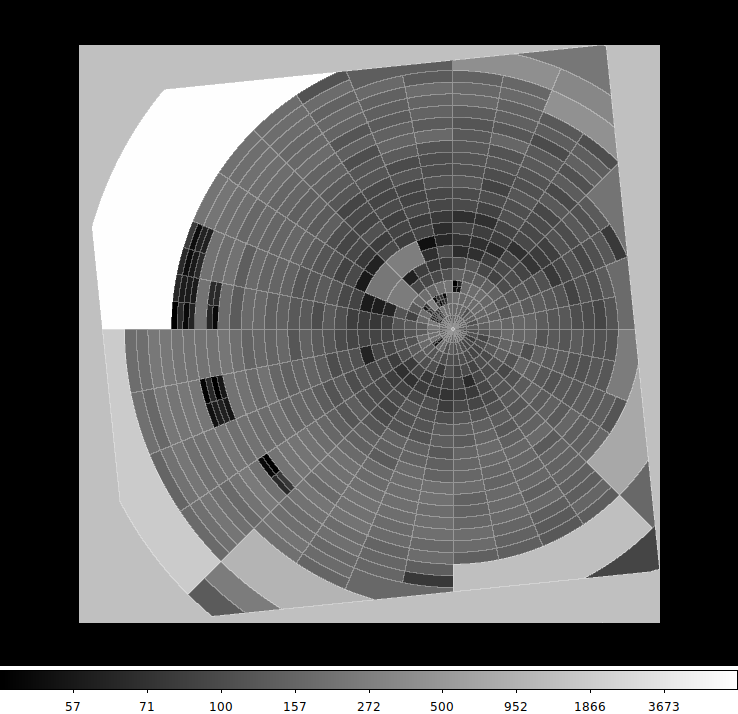

In [28]:
ds9 ngc7618_count.map -zoom to 0.5 \
  -mask color white -mask transparency 70 -mask ngc7618.grid \
  -scale log \
  -saveimage png ds9_11.png -quit

display < ds9_11.png

In [29]:
dmstat ngc7618_count.map cen- sig- med-

count_energy
    min:	50 	      @:	( 3621 3767 )
    max:	7279 	      @:	( 3275 4057 )
   mean:	936.8222465 
    sum:	1049684033 
   good:	1120473 
   null:	222799 
